In [1]:
import os
import re
import sys
import glob
import json
import shutil
import skimage
import tifffile
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import ndimage
from matplotlib import pyplot as plt
from matplotlib import colors as mplcolors

from skimage import feature
from skimage import morphology

%load_ext autoreload
%autoreload 2

In [2]:
sys.path.append('/Users/keith.cheveralls/projects/opencell-process/')
from pipeline_process.imaging import image, utils, viz

sys.path.append('/Users/keith.cheveralls/projects/dragonfly-automation/')
import dragonfly_automation.utils
from dragonfly_automation.fov_models import PipelineFOVScorer

In [3]:
with open('/Users/keith.cheveralls/image-data/dragonfly-automation-tests/ML0196_20191009-2/HCS_sites_20191009_INTERPOLATED.pos') as file:
    pos = json.load(file)

# load an example position_list to map linear indices to well_ids
position_inds = []
for ind, p in enumerate(pos['POSITIONS']):
    well_id, site_num = dragonfly_automation.utils.parse_hcs_site_label(p['LABEL'])
    position_inds.append({'ind': ind, 'well_id': well_id})
position_list_well_ids = pd.DataFrame(data=position_inds)

### 2019-09-10

In [ ]:
# manually annotated good FOVs from 20190910
manual_inds = [
    52,55,
    101,147,175
    ,223,221,224,239,251,262,275,299,
    329,340,375,
    406,415,479,
    503,523,526,539,566,570,580,597,
    650,694,
    705,730,736,775,
    823,841,861,
    920,927,934,960,983,987,999,
    1014,1023,1034,1059,1094,
    1121,1138,1141,1190
]

In [ ]:
log_dir = '/Users/keith.cheveralls/image-data/dragonfly-automation-tests/20190910/ML0000_20190910-3/logs/confluency-check'
out_dir = '/Users/keith.cheveralls/image-data/dragonfly-automation-tests/20190910-snaps-only/'

In [ ]:
# classification log
log = pd.read_csv(os.path.join(log_dir, 'confluency-check-log.csv'))

# fix the filepaths in the classification log
log['filename'] = [os.path.join(log_dir, 'confluency-snaps', name) for name in log.snap_filename]

In [ ]:
log.head()

In [ ]:
# all manual
tile = viz.build_tile(
    log.loc[log.position_ind.isin(manual_inds)], 
    shape=(5, 12), figsize=18)

In [ ]:
# all prediction
tile = viz.build_tile(log.loc[log.confluency_is_good], shape=(6, 12), figsize=18)

In [ ]:
# in manual and prediction
inds = np.array(list(set(prediction_inds).intersection(manual_inds)))
tile = viz.build_tile(log.loc[log.position_ind.isin(inds)], shape=(2, 10), figsize=18)

In [ ]:
# in prediction but not in manual
inds = np.array(list(set(prediction_inds).difference(manual_inds)))
tile = viz.build_tile(log.loc[log.position_ind.isin(inds)], shape=(5, 10), figsize=18)

In [ ]:
# in manual but not in prediction
inds = np.array(list(set(manual_inds).difference(prediction_inds)))
tile = viz.build_tile(log.loc[log.position_ind.isin(inds)], shape=(4, 10), figsize=18)

### 2019-10-03

This was the first half of Plate11. The test was successful but the acquired images are useful, because of the bug in `acquire_snap` method that caused the classified FOVs to lag one behind the current stage position.

Note that this was the last test prior to the major change from per-FOV classification to per-well FOV scoring.

In [ ]:
log_dir = '/Users/keith.cheveralls/image-data/dragonfly-automation-tests/20191003/ML0000_20191003-3/logs/fov-classification/'
out_dir = '/Users/keith.cheveralls/image-data/dragonfly-automation-tests/20191003-snaps-only/'

In [ ]:
# classification log
log = pd.read_csv(os.path.join(log_dir, 'fov-classification-log.csv'))

# fix the filepaths in the classification log
filepaths = log.image_filepath.values
log['filename'] = [os.path.join(log_dir, 'fov-images', path.split('\\')[-1]) for path in filepaths]

In [ ]:
log.head()

In [ ]:
prediction_inds = log.loc[log.decision].position_ind.values
len(prediction_inds)

In [ ]:
# all prediction
tile = viz.build_tile(log.loc[log.position_ind.isin(prediction_inds)], shape=(6, 12), figsize=18)

### ML0196 (2019-10-09)

This is the first half of plate11 (again). This was the first test that used the FOV score-regression model and visited and scored all positions in each well first before acquiring stacks at one the highest-scoring FOVs.

This was also the first test that was retroactively assigned an ML ID and considered to be a 'real' or 'production' imaging experiment. 

Note that the second half of Plate11 was not imaged (we jumped 'ahead', in order of the thawing for mass spec prep, to the first half of Plate10).

In [55]:
log_dir = '/Users/keith.cheveralls/image-data/dragonfly-automation-tests/ML0196_20191009-2/logs/'

log = pd.read_csv(os.path.join(log_dir, 'fov-classification', 'fov-classification-log.csv'))
aqlog = pd.read_csv(os.path.join(log_dir, 'ML0000_20191009-2_acquired-images.csv'))

# fix the filepaths in the classification log
filepaths = log.image_filepath.values
log['filename'] = [os.path.join(log_dir, 'fov-classification', 'fov-images', path.split('\\')[-1]) for path in filepaths]

In [42]:
# numbers: total FOVs, score > -.5, score > 0, acquired FOVS
log.shape[0], (log.score > -.5).sum(), (log.score > 0).sum(), aqlog.shape[0]/2

(1200, 291, 161, 180.0)

In [ ]:
aqlog.head()

In [ ]:
# exposure times by position_ind
plt.scatter(aqlog.position_ind[1::2], aqlog.exposure_time[1::2])

In [ ]:
# numbers: total FOVs, score > -.5, score > 0, acquired FOVS
log.shape[0], (log.score > -.5).sum(), (log.score > 0).sum(), aqlog.shape[0]/2

In [ ]:
# check that all acquired positions had scores above -0.5 (the threshold we used)
set(aqlog.position_ind).difference(log.loc[log.score > -.5].position_ind)

In [ ]:
# distribution of scores (all and acquired)
bins = np.arange(-1, 1, .2)
_ = plt.hist(log.score, bins=bins, density=True)
_ = plt.hist(log.loc[log.position_ind.isin(aqlog.position_ind)].score, bins=bins, density=True, alpha=.5)

In [ ]:
# number of FOVs per well
d = aqlog.groupby('well_id').count().reset_index()
plt.figure(figsize=(12, 2))
plt.plot(d.well_id, d.timestamp/2)
plt.gca().set_ylim([0, 7])

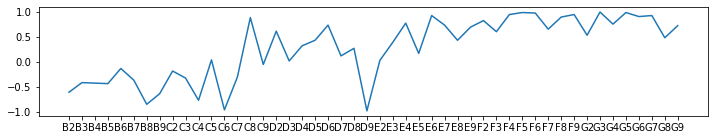

In [56]:
d = pd.merge(position_list_well_ids, log, left_on='ind', right_on='position_ind')
d = d.groupby('well_id').max().reset_index()
plt.figure(figsize=(12, 2))
plt.plot(d.well_id, d.score)
# plt.gca().set_ylim([0, 7])

In [ ]:
# tile acquired FOVs
tile = viz.build_tile(
    log.loc[log.position_ind.isin(aqlog.position_ind)].sort_values(by='score'), 
    shape=(16, 16), 
    figsize=24, 
    offset=0, 
    show_labels=True, 
    label_column='score')

In [ ]:
# tile FOVs with a certain score
tile = viz.build_tile(
    log.loc[log.score < -.5].sort_values(by='score', ascending=False), 
    shape=(20, 16), 
    figsize=24, 
    offset=320*0, 
    show_labels=True, 
    label_column='score')

### ML0197 (2019-10-23)

This is the first half of Plate10. 

In [53]:
log_dir = '/Users/keith.cheveralls/image-data/dragonfly-automation-tests/ML0197_20191023-4/logs/'

log = pd.read_csv(os.path.join(log_dir, 'fov-classification', 'fov-classification-log.csv'))
aqlog = pd.read_csv(os.path.join(log_dir, 'ML0000_20191023-4_acquired-images.csv'))
afclog = pd.read_csv(os.path.join(log_dir, 'ML0000_20191023-4_afc-calls.csv'))

filepaths = log.image_filepath.values
log['filename'] = [os.path.join(log_dir, 'fov-classification', 'fov-images', path.split('\\')[-1]) for path in filepaths]

In [38]:
# numbers: total FOVs, score > -.5, score > 0, acquired FOVS
log.shape[0], (log.score > -.5).sum(), (log.score > 0).sum(), aqlog.shape[0]/2

(1200, 307, 182, 186.0)

In [39]:
afclog.shape, afclog.afc_error.isna().sum()

((1478, 7), 1478)

In [ ]:
plt.scatter(afclog.focusdrive_position_before, afclog.focusdrive_position_after)

In [ ]:
_ = plt.hist(afclog.focusdrive_position_after - afclog.focusdrive_position_before, bins=10)

In [ ]:
_ = plt.hist(afclog.score_before, alpha=.5, bins=np.linspace(-200, 200, 50))
# _ = plt.hist(afclog.score_after, alpha=.5, bins=np.linspace(-200, 200, 50))

In [ ]:
plt.scatter(
    afclog.focusdrive_position_after - afclog.focusdrive_position_before,
    afclog.score_before,
    alpha=.5)

plt.gca().set_ylim([-200, 200])

In [ ]:
afclog.loc[afclog.score_before < -1e3]

In [ ]:
# number of FOVs per well
d = aqlog.groupby('well_id').count().reset_index()
plt.figure(figsize=(12, 2))
plt.plot(d.well_id, d.timestamp/2)
plt.gca().set_ylim([0, 7])

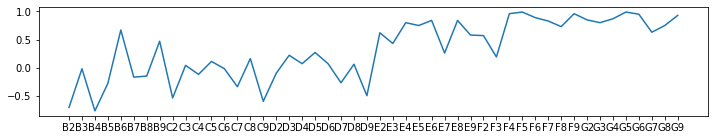

In [54]:
# Mean FOV score by well
d = pd.merge(position_list_well_ids, log, left_on='ind', right_on='position_ind')
d = d.groupby('well_id').max().reset_index()
plt.figure(figsize=(12, 2))
plt.plot(d.well_id, d.score)
# plt.gca().set_ylim([0, 7])

In [ ]:
d.sort_values(by='score')

In [ ]:
# tile acquired FOVs
tile = viz.build_tile(
    log.loc[log.position_ind.isin(aqlog.position_ind)].sort_values(by='score'), 
    shape=(12, 16), 
    figsize=24, 
    offset=0, 
    show_labels=True, 
    label_column='score')

### ML0198 (2019-10-24)

This is the second half of Plate10. This failed for multiple reasons, including frequent AFC timeouts (see below) and the fact that the microscope computer ran out of disk space early in the acquisition.

We added an offset of 20um to the interpolated positions, and observed frequent AFC timeouts. We concluded that this was a bad idea.

Note that the logs of this experiment are useful only for investigating how the AFC timeout errors were handled. 

### ML0201 (2019-10-29)

This is the second half of Plate10 again, after the failure of ML0198.

In [49]:
log_dir = '/Users/keith.cheveralls/image-data/dragonfly-automation-tests/ML0201_20191029-1/logs/'

log = pd.read_csv(os.path.join(log_dir, 'fov-classification', 'fov-classification-log.csv'))
aqlog = pd.read_csv(os.path.join(log_dir, 'ML0201_20191029-1_acquired-images.csv'))
afclog = pd.read_csv(os.path.join(log_dir, 'ML0201_20191029-1_afc-calls.csv'))

# fix the filepaths in the classification log
filepaths = log.image_filepath.values
log['filename'] = [os.path.join(log_dir, 'fov-classification', 'fov-images', path.split('\\')[-1]) for path in filepaths]

In [23]:
afclog.shape, afclog.afc_error.isna().sum()

((1267, 7), 1267)

In [24]:
# numbers: total FOVs, score > -.5, score > 0, acquired FOVS
log.shape[0], (log.score > -.5).sum(), (log.score > 0).sum(), aqlog.shape[0]/2

(1200, 11, 4, 11.0)

In [ ]:
# number of FOVs per well
d = aqlog.groupby('well_id').count().reset_index()
plt.figure(figsize=(12, 2))
plt.plot(d.well_id, d.timestamp/2)
plt.gca().set_ylim([0, 7])

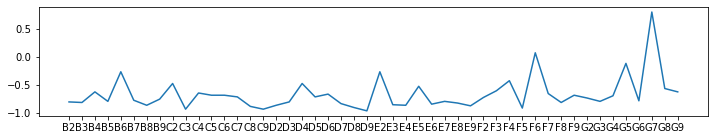

In [50]:
# Mean FOV score by well
d = pd.merge(position_list_well_ids, log, left_on='ind', right_on='position_ind')
d = d.groupby('well_id').max().reset_index()
plt.figure(figsize=(12, 2))
plt.plot(d.well_id, d.score)
# plt.gca().set_ylim([0, 7])

### ML0202 (2019-10-30)

This is the first half of Plate7.

In this experiment, we also acquired brightfield stacks for the first time, using the same z-stack settings. The BF images were appended to the raw TIFF stacks as a third channel.

In [51]:
log_dir = '/Users/keith.cheveralls/image-data/dragonfly-automation-tests/ML0202_20191030-1/logs/'

log = pd.read_csv(os.path.join(log_dir, 'fov-classification', 'fov-classification-log.csv'))
aqlog = pd.read_csv(os.path.join(log_dir, 'ML0202_20191030-1_acquired-images.csv'))
afclog = pd.read_csv(os.path.join(log_dir, 'ML0202_20191030-1_afc-calls.csv'))

# fix the filepaths in the classification log
filepaths = log.image_filepath.values
log['filename'] = [os.path.join(log_dir, 'fov-classification', 'fov-images', path.split('\\')[-1]) for path in filepaths]

In [30]:
afclog.shape, afclog.afc_error.isna().sum()

((1400, 7), 1398)

In [31]:
# numbers: total FOVs, score > -.5, score > 0, acquired FOVS
log.shape[0], (log.score > -.5).sum(), (log.score > 0).sum(), aqlog.shape[0]/3

(1200, 147, 59, 119.0)

In [ ]:
# number of FOVs per well
d = aqlog.groupby('well_id').count().reset_index()
plt.figure(figsize=(12, 2))
plt.plot(d.well_id, d.timestamp/3)
plt.gca().set_ylim([0, 7])

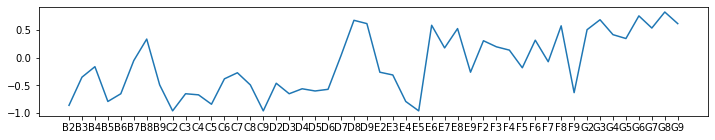

In [52]:
# Mean FOV score by well
d = pd.merge(position_list_well_ids, log, left_on='ind', right_on='position_ind')
d = d.groupby('well_id').max().reset_index()
plt.figure(figsize=(12, 2))
plt.plot(d.well_id, d.score)
# plt.gca().set_ylim([0, 7])

In [ ]:
# tile acquired FOVs
tile = viz.build_tile(
    log.loc[log.position_ind.isin(aqlog.position_ind)].sort_values(by='score'), 
    shape=(10, 12), 
    figsize=24, 
    offset=0, 
    show_labels=True, 
    label_column='score')

In [ ]:
log.loc[log.position_ind.isin(aqlog.position_ind)].sort_values(by='score')

### ML0205 (2019-10-31)

This is the second half of Plate7.

In this experiment, we acquired brightfield stacks again, but this time using different z-stack settings (-20 to +20 with 1um step size) and different aperture and field stop settings (aperture at 4 and field stop at 25).

In [5]:
log_dir = '/Users/keith.cheveralls/image-data/dragonfly-automation-tests/ML0205_20191031-1/logs/'

log = pd.read_csv(os.path.join(log_dir, 'fov-classification', 'fov-classification-log.csv'))
aqlog = pd.read_csv(os.path.join(log_dir, 'ML0205_20191031-1_acquired-images.csv'))
afclog = pd.read_csv(os.path.join(log_dir, 'ML0205_20191031-1_afc-calls.csv'))

# fix the filepaths in the classification log
filepaths = log.image_filepath.values
log['filename'] = [os.path.join(log_dir, 'fov-classification', 'fov-images', path.split('\\')[-1]) for path in filepaths]

In [6]:
afclog.shape, afclog.afc_error.isna().sum()

((1482, 7), 1482)

In [7]:
# numbers: total FOVs, score > -.5, score > 0, acquired FOVS
log.shape[0], (log.score > -.5).sum(), (log.score > 0).sum(), aqlog.shape[0]/3

(1200, 323, 142, 195.0)

(0, 7)

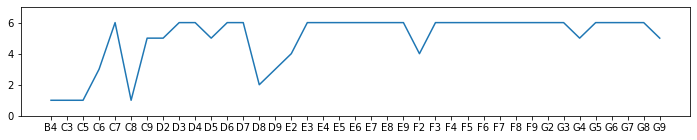

In [8]:
# number of FOVs per well
d = aqlog.groupby('well_id').count().reset_index()
plt.figure(figsize=(12, 2))
plt.plot(d.well_id, d.timestamp/3)
plt.gca().set_ylim([0, 7])

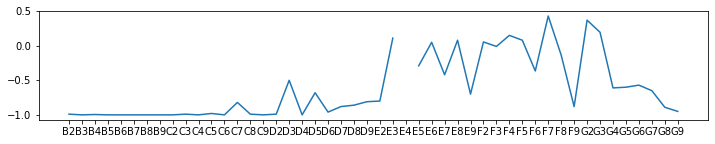

In [32]:
# Mean FOV score by well
d = pd.merge(position_list_well_ids, log, left_on='ind', right_on='position_ind')
d = d.groupby('well_id').median().reset_index()
plt.figure(figsize=(12, 2))
plt.plot(d.well_id, d.score)
# plt.gca().set_ylim([0, 7])

In [ ]:
# tile acquired FOVs
tile = viz.build_tile(
    log.loc[log.position_ind.isin(aqlog.position_ind)].sort_values(by='score', ascending=False), 
    shape=(10, 12), 
    figsize=24, 
    offset=0, 
    show_labels=True, 
    label_column='score')

In [12]:
# parse metadata from ML0205 to extract the aperture and field stop settings (for BF channel)
with open('/Users/keith.cheveralls/image-data/dragonfly-automation-tests/ML0205_20191031-1/raw_data/MMStack_134-B4-9_metadata.txt') as file:
    d = json.load(file)

In [ ]:
# the relevant keys are 'TL-FieldDiaphragm-Position', 'TL-ApertureDiaphragm-Position', 'Transmitted Light-Level'
{key: val for key, val in d['FrameKey-0-0-0'].items() if key.startswith('T')}

### ML0212 (2019-11-12)

This is the first half of plate12 (for the second time, after last week's ML0206 failed, both because the plate was left uncovered by accident and because very few FOVs were acquired). 

__Changes__
- nomenclature change from 'classification' to 'scoring'. For example, 'fov-classification' directory is now 'fov-scoring'
- we now always acquire one FOV per well, even if no FOVs were acceptable (had a score above -0.5)

__Issues__

There were frequent AFC timeouts, and some of the acquired stacks are out of focus (check for focus using the are_nuclei_in_fov method)

In [17]:
log_dir = '/Users/keith.cheveralls/image-data/dragonfly-automation-tests/ML0212_20191112/logs/'

log = pd.read_csv(os.path.join(log_dir, 'fov-scoring', 'fov-score-log.csv'))
aqlog = pd.read_csv(os.path.join(log_dir, 'ML0212_20191112-1_acquired-images.csv'))
afclog = pd.read_csv(os.path.join(log_dir, 'ML0212_20191112-1_afc-calls.csv'))

# fix the filepaths in the classification log
filepaths = log.image_filepath.values
log['filename'] = [os.path.join(log_dir, 'fov-scoring', 'fov-images', path.split('\\')[-1]) for path in filepaths]

In [19]:
afclog.columns

Index(['timestamp', 'score_before', 'score_after',
       'focusdrive_position_before', 'focusdrive_position_after', 'afc_error',
       'position_ind'],
      dtype='object')

In [18]:
# numbers: total FOVs, score > -.5, score > 0, acquired FOVS
log.shape[0], (log.score > -.5).sum(), (log.score > 0).sum(), aqlog.shape[0]/3

(1200, 343, 210, 192.0)

(0, 7)

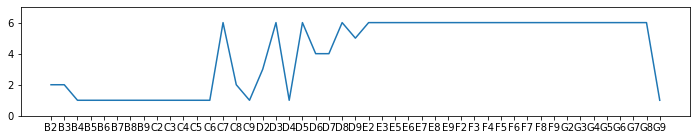

In [7]:
# number of FOVs per well
d = aqlog.groupby('well_id').count().reset_index()
plt.figure(figsize=(12, 2))
plt.plot(d.well_id, d.timestamp/3)
plt.gca().set_ylim([0, 7])

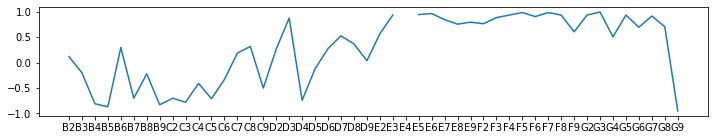

In [8]:
# Mean FOV score by well
d = pd.merge(position_list_well_ids, log, left_on='ind', right_on='position_ind')
d = d.groupby('well_id').max().reset_index()
plt.figure(figsize=(12, 2))
plt.plot(d.well_id, d.score)
# plt.gca().set_ylim([0, 7])

In [ ]:
# tile acquired FOVs
tile = viz.build_tile(
    log.loc[log.position_ind.isin(aqlog.position_ind)].sort_values(by='score', ascending=False), 
    shape=(15, 15), 
    figsize=24, 
    offset=0, 
    show_labels=True, 
    label_column='score')

In [46]:
tiff = image.RawPipelineTIFF(
    '/Users/keith.cheveralls/image-data/dragonfly-automation-tests/ML0212_20191112/raw_data/MMStack_8-B9-8.ome.tif')

In [47]:
tiff.parse_micromanager_metadata()

In [ ]:
plt.plot(tiff.mm_metadata.channel_ind)

In [49]:
mm = tiff.mm_metadata
dapi = np.array([tiff.tiff.pages[ind].asarray() for ind in mm.loc[mm.channel_ind==0].page_ind])
bf = np.array([tiff.tiff.pages[ind].asarray() for ind in mm.loc[mm.channel_ind==2].page_ind])

In [50]:
bf.shape, dapi.mean()

((41, 1024, 1024), 706.5192695050627)

In [51]:
scorer = PipelineFOVScorer(mode='training')
scorer.are_nuclei_in_fov(dapi.max(axis=0))

True

### ML0213 (2019-11-13)

AFC-related changes:
- the AFC method now tries multiple FocusDrive offsets if the initial call to AFC times out
- The columns of the AFC log itself were all renamed
- the afc_did_succeed flag was added to the acquisitions log


In [5]:
log_dir = '/Users/keith.cheveralls/image-data/dragonfly-automation-tests/ML0213_20191113/logs/'

log = pd.read_csv(os.path.join(log_dir, 'fov-scoring', 'fov-score-log.csv'))
aqlog = pd.read_csv(os.path.join(log_dir, 'ML0213_20191113-2_acquired-images.csv'))
afclog = pd.read_csv(os.path.join(log_dir, 'ML0213_20191113-2_afc-calls.csv'))

# fix the filepaths in the classification log
filepaths = log.image_filepath.values
log['filename'] = [os.path.join(log_dir, 'fov-scoring', 'fov-images', path.split('\\')[-1]) for path in filepaths]

In [6]:
# numbers: total FOVs, score > -.5, score > 0, acquired FOVS
log.shape[0], (log.score > -.5).sum(), (log.score > 0).sum(), aqlog.shape[0]/3

(1200, 23, 6, 100.0)

In [14]:
# number of failed AFC calls
afclog.afc_did_succeed.isna().sum()

0

(0, 7)

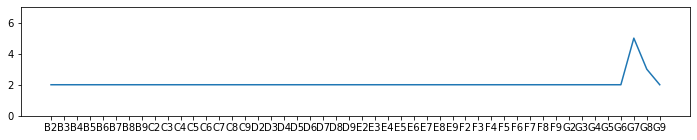

In [7]:
# number of FOVs per well
d = aqlog.groupby('well_id').count().reset_index()
plt.figure(figsize=(12, 2))
plt.plot(d.well_id, d.timestamp/3)
plt.gca().set_ylim([0, 7])

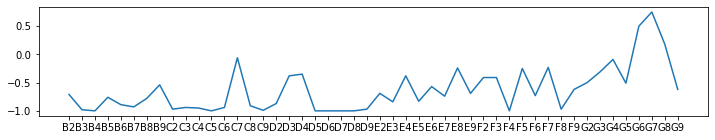

In [8]:
# Mean FOV score by well
d = pd.merge(position_list_well_ids, log, left_on='ind', right_on='position_ind')
d = d.groupby('well_id').max().reset_index()
plt.figure(figsize=(12, 2))
plt.plot(d.well_id, d.score)
# plt.gca().set_ylim([0, 7])

In [ ]:
# tile acquired FOVs
tile = viz.build_tile(
    log.loc[log.position_ind.isin(aqlog.position_ind)].sort_values(by='score', ascending=False), 
    shape=(10, 10), 
    figsize=24, 
    offset=0, 
    show_labels=True, 
    label_column='score')

In [ ]:
tiff = image.RawPipelineTIFF(
    '/Users/keith.cheveralls/image-data/dragonfly-automation-tests/ML0213_20191113/raw_data/MMStack_1180-G9-5.ome.tif')

In [ ]:
tiff.parse_micromanager_metadata()

In [ ]:
plt.plot(tiff.mm_metadata.channel_ind)

In [ ]:
mm = tiff.mm_metadata
dapi = np.array([tiff.tiff.pages[ind].asarray() for ind in mm.loc[mm.channel_ind==0].page_ind])
gfp = np.array([tiff.tiff.pages[ind].asarray() for ind in mm.loc[mm.channel_ind==1].page_ind])
bf = np.array([tiff.tiff.pages[ind].asarray() for ind in mm.loc[mm.channel_ind==2].page_ind])

In [ ]:
bf.shape, dapi.max(), gfp.max()

In [ ]:
scorer = PipelineFOVScorer(mode='training')
scorer.are_nuclei_in_fov(dapi.max(axis=0))

In [ ]:
viz.imshow(bf[11, :, :])

### ML0214 (2019-11-14)

Changes
- dropped the experiment_name (e.g., 'ML0214_20191114') from all of the log filenames
- 